<a href="https://colab.research.google.com/github/mvdheram/Social-bias-Detection/blob/main/Transformer_based_Anti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# distilBERT

In [ ]:
pip install ktrain

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

#### Importing data 

In [ ]:
import ktrain
from ktrain import text
import pandas as pd

In [ ]:
dataset = pd.read_csv('/content/combined_stereo_antiStereo.csv', index_col=0)

In [ ]:
len(dataset)

9966

In [ ]:
dataset.head()

,sentences,stereo_antistereo
0,His mind wondered if a doctor was behind this ...,anti-stereotype
1,The woman was highly skilled in CAD engineerin...,anti-stereotype
2,Hispanics are good at reading,anti-stereotype
3,He felt threatened by the presence of the tiny...,anti-stereotype
4,The construction worker's wheelchair got stuck...,anti-stereotype


In [ ]:
from sklearn.utils import shuffle
dataset = shuffle(dataset)

In [ ]:
dataset.stereo_antistereo.value_counts()

stereotype         5519
anti-stereotype    4447
Name: stereo_antistereo, dtype: int64

In [ ]:
X = dataset.iloc[:,0].values
y = dataset.iloc[:,1].values

In [ ]:
print(X)

['Corey was the only Latino person on his team.'
 'Have you ever seen a producer so egotistical?'
 'The black made sure he had his gun, he was coming up on dough or going to jail for bank robbery.'
 ...
 'Clients seemed to hate the face time though, due to his Muslim attire.'
 'Crimeans are very professional.'
 'I met with a historian at the University. She was a beautiful woman.']


In [ ]:
print(y)

['stereotype' 'stereotype' 'stereotype' ... 'stereotype' 'anti-stereotype'
 'anti-stereotype']


Splitting the dataset into training and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
categories = dataset.stereo_antistereo.unique()
print(categories)

['stereotype' 'anti-stereotype']


####  Building model using distilBERT

In [ ]:
model_name = 'distilbert-base-uncased'

trans = text.Transformer(model_name = model_name ,maxlen=512, class_names= categories)

In [ ]:
train_df = trans.preprocess_train(X_train,y_train)
test_df = trans.preprocess_test(X_test,y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 12
	95percentile : 23
	99percentile : 31


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 12
	95percentile : 24
	99percentile : 31


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model,train_data = train_df,val_data= test_df, batch_size= 16)

Finding best learning rate

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
498/498 [==============================] - 274s 531ms/step - loss: 0.6889 - accuracy: 0.5419
Epoch 2/5
498/498 [==============================] - 266s 534ms/step - loss: 0.6314 - accuracy: 0.6349
Epoch 3/5
498/498 [==============================] - 265s 533ms/step - loss: 0.6659 - accuracy: 0.5737
Epoch 4/5
498/498 [==============================] - 220s 441ms/step - loss: 11.5238 - accuracy: 0.5393


done.
Visually inspect loss plot and select learning rate associated with falling loss


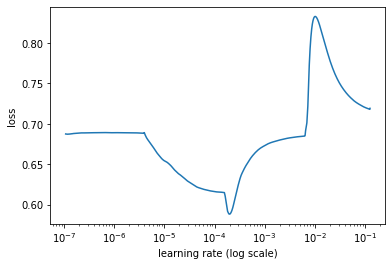

In [ ]:
learner.lr_find(show_plot=True,max_epochs=5)

In [ ]:
learner.fit_onecycle(1e-4,5)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/5
499/499 [==============================] - 277s 540ms/step - loss: 0.6517 - accuracy: 0.5918 - val_loss: 0.5476 - val_accuracy: 0.7227
Epoch 2/5
499/499 [==============================] - 270s 538ms/step - loss: 0.4903 - accuracy: 0.7527 - val_loss: 0.5543 - val_accuracy: 0.7307
Epoch 3/5
499/499 [==============================] - 270s 537ms/step - loss: 0.3804 - accuracy: 0.8255 - val_loss: 0.5808 - val_accuracy: 0.7337
Epoch 4/5
499/499 [==============================] - 270s 538ms/step - loss: 0.2320 - accuracy: 0.9056 - val_loss: 0.6529 - val_accuracy: 0.7558
Epoch 5/5
499/499 [==============================] - 270s 538ms/step - loss: 0.0818 - accuracy: 0.9711 - val_loss: 0.8755 - val_accuracy: 0.7603


In [ ]:
learner.validate(class_names=trans.get_classes())

                 precision    recall  f1-score   support

anti-stereotype       0.73      0.72      0.72       865
     stereotype       0.79      0.79      0.79      1129

       accuracy                           0.76      1994
      macro avg       0.76      0.76      0.76      1994
   weighted avg       0.76      0.76      0.76      1994



array([[622, 243],
       [235, 894]])

In [ ]:
learner.view_top_losses(n=5, preproc=trans)

----------
id:1457 | loss:7.14 | true:anti-stereotype | pred:stereotype)

----------
id:837 | loss:7.14 | true:anti-stereotype | pred:stereotype)

----------
id:1836 | loss:7.08 | true:stereotype | pred:anti-stereotype)

----------
id:49 | loss:7.07 | true:anti-stereotype | pred:stereotype)

----------
id:769 | loss:7.07 | true:anti-stereotype | pred:stereotype)



In [ ]:
print(X_test[1457])

Africans live in africa, These people are usually criminals


In [ ]:
predictor = ktrain.get_predictor(learner.model,preproc=trans)

In [ ]:
predictor.get_classes()

['anti-stereotype', 'stereotype']

In [ ]:
predictor.predict_proba(X_test[1457])

array([7.9312839e-04, 9.9920684e-01], dtype=float32)

## Explainable AI : 

Methods and techniques help to understand how AI model reaches particular conclusion.

Paper : LIME- Local Interpretable Model agnostic Explanation ( a novel explanation technique that explains the predictions of any classifier ) https://arxiv.org/abs/1602.04938

Colors :

GREEN : Words that contribute to the prediction.

RED/PINK : Words that detract from prediction. 




In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [ ]:
predictor.explain(X_test[1457])

In [ ]:
predictor.explain(X_test[837])

In [ ]:
predictor.explain(X_test[1836])

#### Predicting new value

In [ ]:
predictor.predict_proba(' You dont _seem_ gay.')

array([0.00132666, 0.9986733 ], dtype=float32)

In [ ]:
predictor.predict("You're pretty for a black girl")

'stereotype'

In [ ]:
predictor.predict("I don't like short hair on girls.")

'stereotype'

In [ ]:
predictor.save('/tmp/my_distilbert_predictor2')

In [ ]:
reloaded_predictor = ktrain.load_predictor('/tmp/my_distilbert_predictor2')

In [ ]:
reloaded_predictor.predict("I don't like short hair on girls.")

'stereotype'

In [ ]:
reloaded_predictor.explain("I don't like short hair on girls.")

In [ ]:
x = "he seems woman than man"

In [ ]:
reloaded_predictor.explain(x)

In [ ]:
reloaded_predictor.explain('That bitch got 5 million boyfriends')

In [ ]:
reloaded_predictor.explain("African people are good ")

In [ ]:
reloaded_predictor.explain("African people are good at running")

**Rough overview**

*Intended Goals of thesis* :

1. A literature survey on social bias in NLP tasks and models.
2. Assessing the use of pre-trained language models to detect presence of social bias as compared to feature based classifiers (lexicons, sentiment, n-grams ..).
3. How social bias affects the quality of arguments; explained using the quality dimentions of natural language argumentation. 



